## TP Final - Inteligencia Artificial

María_Carina_Roldán 
Eloy_Zerbatto_Diaz 
5ta Cohorte

## Consigna

A partir del dataset www.kaggle.com/datasets/abrambeyer/openintro-possum

a. Clasificar el ejemplar en m/f

b. Predecir totlngth

Los dos items son independientes entre sí, es decir, pueden usar como predictor en A la variable target del B, y visceversa.

Usar al menos dos modelos en cada caso y comparar los resultados.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
data = pd.read_csv('data/possum.csv')
data = pd.DataFrame(data)
data.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


El dataset possum consta de nueve medidas morfométricas en cada una de 104 zarigüeyas de montaña.


In [3]:
# Codifica las features Pop (population) y sexo
le_Pop = preprocessing.LabelEncoder()
le_sex = preprocessing.LabelEncoder()
le_Pop.fit(data.iloc[:,2])
le_sex.fit(data.iloc[:,3])

# Arma un nuevo dataset con features numéricas
data_ = np.array(data)
data_num = data_
data_num[:,2]=le_Pop.transform(data_[:,2])
data_num[:,3]=le_sex.transform(data_[:,3])
data_num = np.array(data_num, dtype=float)

# Verifica que no haya Nan, si los hay, los corrije
if np.sum(np.isnan(data_num)) > 0: 
    data_num =pd.DataFrame(data_num)
    data_num = data_num.fillna(data_num.mean())
    data_num = np.array(data_num,float)


In [4]:
# Matriz de correlación para tener una primera idea de cómo se relacionan las features
corr = pd.DataFrame(data_num, 
                    columns = ["case", "site", "Pop", "sex", "age", "hdlngth", "skullw", "totlngth", "taill", "footlgth", "earconch", "eye", "chest", "belly"]
                    ).corr()
corr.style.background_gradient(cmap='viridis').format(precision=3)


,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
case,1.000,0.970,0.860,0.254,-0.194,-0.209,-0.125,-0.334,0.315,-0.782,-0.774,-0.084,-0.402,-0.212
site,0.970,1.000,0.892,0.233,-0.131,-0.164,-0.084,-0.261,0.380,-0.781,-0.791,-0.037,-0.345,-0.175
Pop,0.860,0.892,1.000,0.196,-0.086,0.001,0.066,-0.079,0.491,-0.788,-0.883,0.149,-0.195,-0.025
sex,0.254,0.233,0.196,1.000,-0.064,0.107,0.080,-0.160,-0.041,-0.123,-0.092,0.188,-0.139,-0.091
age,-0.194,-0.131,-0.086,-0.064,1.000,0.312,0.280,0.251,0.117,0.125,0.053,0.235,0.325,0.346
hdlngth,-0.209,-0.164,0.001,0.107,0.312,1.000,0.711,0.691,0.287,0.389,0.121,0.347,0.631,0.563
skullw,-0.125,-0.084,0.066,0.080,0.280,0.711,1.000,0.526,0.256,0.275,-0.001,0.322,0.630,0.452
totlngth,-0.334,-0.261,-0.079,-0.160,0.251,0.691,0.526,1.000,0.566,0.443,0.154,0.248,0.578,0.519
taill,0.315,0.380,0.491,-0.041,0.117,0.287,0.256,0.566,1.000,-0.126,-0.385,0.198,0.175,0.294
footlgth,-0.782,-0.781,-0.788,-0.123,0.125,0.389,0.275,0.443,-0.126,1.000,0.769,0.005,0.451,0.302


### Observaciones

- El sexo no parece estar directamente correlacionado con ninguna de las features. Igualmente intentaremos clasificar estas zarigüeyas como m/f.
- Por otro lado, el largo total (totlngth) sí parece tener correlacionado con otras features, en particular con el largo de la cabeza (hdlength), el ancho del cráneo (skullw), el largo de la cola (taill), la circunferencia del pecho (chest) y la de la panza (belly).


# Clasificador M/H

In [5]:
# Se elimina la columna de sexo en la tabla y se genera la nueva tabla X
X = np.delete(data_num,3,1)

# se crea el vector de features
Y = data_num[:,3]

### PCA

Escalamos los datos y aplicamos PCA

In [6]:
RANDOM_STATE = 20

In [7]:
TRAIN_SIZE = 0.8
x_train,x_test, y_train, y_test =  train_test_split(X,Y,train_size = TRAIN_SIZE,shuffle =True,random_state=RANDOM_STATE)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

EXP_VAR_PER = 0.9
pca = PCA(EXP_VAR_PER,random_state=RANDOM_STATE)
pca.fit(x_train_scaled)
print(len(pca.components_))

6


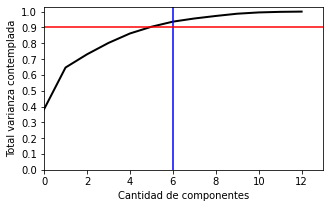

In [8]:
pca_2 = PCA(n_components=np.shape(x_train)[1], random_state=RANDOM_STATE).fit(x_train_scaled)

plt.figure(figsize=(5,3))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, np.shape(x_train)[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(len(pca.components_), c='b')
plt.axhline(EXP_VAR_PER, c='r')
plt.show();

6 componentes alcanzan para explicar el 90% de la varianza de los datos

In [9]:
# Separamos datos de training y test
x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

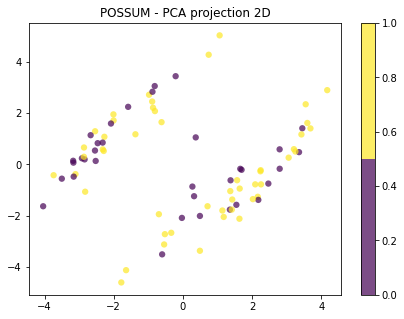

In [10]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(7,5))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('viridis', 2))
plt.colorbar()
plt.title('POSSUM - PCA projection 2D');

Lo que esperaríamos observar en esta visualización de componentes principales es una clara separación de las dos clases. En cambio se observa bastante superposición entre las distintas muestras.

## K-means

Probamos clusterizar con k-means

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         9
         1.0       0.75      0.75      0.75        12

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21



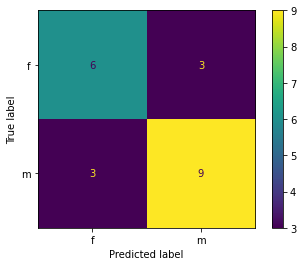

In [11]:
# Clusterizamos, predecimos y generamos una matriz de confusión
n_clusters = len(list(set(Y)))
kmeans_model = KMeans(n_clusters,random_state = RANDOM_STATE)
kmeans_model.fit(x_train_scaled)
y_pred = kmeans_model.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = list(le_sex.classes_))
disp.plot()
print(classification_report(y_test, y_pred))


## K-means with PCA

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         9
         1.0       0.75      0.75      0.75        12

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21



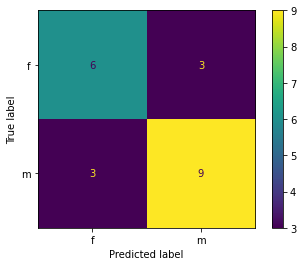

In [12]:
n_clusters = len(list(set(Y)))
kmeans_model = KMeans(n_clusters,random_state = RANDOM_STATE )
kmeans_model.fit(x_train_pca)
y_pred = kmeans_model.predict(x_test_pca)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = list(le_sex.classes_))
disp.plot()
print(classification_report(y_test, y_pred))

### Observaciones

Tanto aplicando PCA o no, usar k-means para clasificar la feature no tuvo un buen resultado.

## Regresión logística

Como segundo método de clasificación vamos a aplicar regresión logística

In [13]:
RANDOM_STATE = 11

              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         9
         1.0       0.60      0.75      0.67        12

    accuracy                           0.57        21
   macro avg       0.55      0.54      0.53        21
weighted avg       0.56      0.57      0.55        21



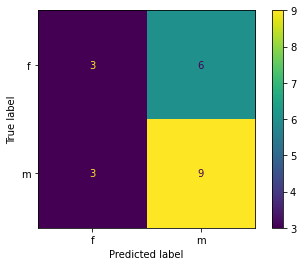

In [14]:
# Aplicamos LR, predecimos y generamos una matriz de confusión
rlog = LogisticRegression(solver = 'liblinear', penalty ='l1',random_state=RANDOM_STATE).fit(x_train_scaled,y_train)
y_pred = rlog.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = list(le_sex.classes_))
disp.plot()
print(classification_report(y_test, y_pred))


### Observaciones

Comparado con k-means, la regresión logística no mejoró. En particular clasificó muy mal el sexo f (muchos FN).

# Predicción "Longitud Total" (totlngth)

In [15]:
# Se elimina la columna totlngth en la tabla y se genera la nueva tabla de features X
X = np.delete(data_num,7,1)

# Se crea el vector con los valores de totlngth
Y = data_num[:,7]

In [16]:
# Separo en train y test
x_train, x_test, y_train, y_test =  train_test_split(X,Y,train_size = 0.8,shuffle =True,random_state=RANDOM_STATE)

Vamos a probar predecir la longitud total con diferentes métodos. Al final, compararemos el MSE.

In [17]:
metrics = []

In [18]:
# Linear Regression
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)
y_hat = lm.predict(x_test)
mse = mean_squared_error(y_test, y_hat)
metrics.append(["LR", mse])
mse

5.075045009235197

In [19]:
# Ridge Regression
lmr = linear_model.Ridge(alpha=0.5)
lmr.fit(x_train, y_train)
y_hat = lmr.predict(x_test)
mse = mean_squared_error(y_test, y_hat)
metrics.append(["Ridge", mse])
mse

5.047923631953497

In [20]:
# Lasso Regression
lml = linear_model.Lasso(alpha=0.5)
lml.fit(x_train, y_train)
y_hat = lml.predict(x_test)
mse = mean_squared_error(y_test, y_hat)
metrics.append(["Lasso", mse])
mse

3.715571741055762

Vamos a probar una regresión para predecir totlngth a partir de hdlngth (que como se vio más arriba, es una de las que muestra una correlación alta con la feature a predecir). 

In [21]:
# Feature hdlngth
x_train_hd = x_train[:,5].reshape(-1, 1)
x_test_hd = x_test[:,5].reshape(-1, 1)

In [22]:
# Linear Regression hdlngth + totlngth
lm = linear_model.LinearRegression()
lm.fit(x_train_hd, y_train)
y_hat = lm.predict(x_test_hd)
mse = mean_squared_error(y_test, y_hat)
metrics.append(["LR hd", mse])
mse

6.947436096974656

In [23]:
# Lasso Regression
lmr = linear_model.Lasso(alpha=0.5)
lmr.fit(x_train_hd, y_train)
y_hat2 = lmr.predict(x_test_hd)
mse = mean_squared_error(y_test, y_hat2)
metrics.append(["Lasso hd", mse])
mse

7.196666908377215

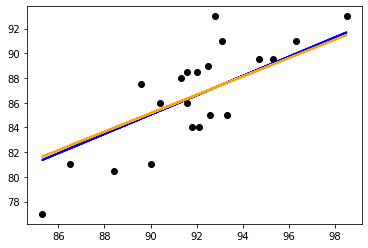

In [24]:
# Plot outputs - Comparación Ridge vs Lasso
plt.scatter(x_test_hd, y_test, color="black")
plt.plot(x_test_hd, y_hat, color="blue", linewidth=2)
plt.plot(x_test_hd, y_hat2, color="orange", linewidth=2)

plt.show()

### Observaciones

- Una sola feature no es suficiente para predecir totlgth.
- No se observan diferencias entre Ridge y Lasso.


### PCA

Probamos ahora PCA para reducir dimensionalidad y volver a intentar una regresión para predecir totlngth.

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.9).fit(X_scaled)
X_pca = pca.transform(X_scaled)

# Cantidad de componentes necesarios para explicar el 90% de la varianza
X_pca.shape[1]

7

In [26]:
# Separo en train y test el dataset reducido
x_pca_train, x_pca_test, y_pca_train, y_pca_test =  train_test_split(X_pca,Y,train_size = 0.8,shuffle =True,random_state=RANDOM_STATE)

In [27]:
# Linear Regression
lm = linear_model.LinearRegression()
lm.fit(x_pca_train, y_pca_train)
y_hat = lm.predict(x_pca_test)
mse = mean_squared_error(y_pca_test, y_hat)
metrics.append(["LR + PCA", mse])
mse

4.392464629744086

### Comparamos los resultados

In [28]:
df = pd.DataFrame(metrics, columns=['caso', 'mse'])
df

,caso,mse
0,LR,5.075045
1,Ridge,5.047924
2,Lasso,3.715572
3,LR hd,6.947436
4,Lasso hd,7.196667
5,LR + PCA,4.392465


<AxesSubplot:ylabel='caso'>

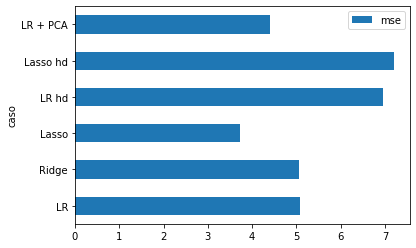

In [29]:
df.plot(kind='barh',x='caso',y='mse')

### Observaciones
El menor MSE se obtuvo al aplicar regresión lineal usando todos los componentes, en particular, Lasso Regression dio los mejores resultados.